In [24]:
"""This file contains the pipeline for training and evaluating the GCN on the data."""
import os
import sys
import random
import numpy as np
import pandas as pd
import datetime
from typeguard import typechecked
import pickle

import networkx
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx

from sklearn.model_selection import train_test_split

from tqdm import tqdm
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader
from src.data.data_processing import standardise_embeddings, convert_networkx_to_torch, get_mask
from src.visualization.visualize import tsne, plot_metrics_during_training

from src.general.utils import cc_path
from src.models.evaluation import Metrics


import matplotlib.pyplot as plt

from src.models.graph_network_models.single_stream_gat import GAT
from src.models.graph_network_models.single_stream_gin import GIN
from src.models.graph_network_models.single_stream_gcn import GCN
from src.models.graph_network_models.single_stream_graphtransformer import GraphTransformer
from src.models.graph_network_models.single_stream_sage import SAGE


from src.models.graph_network_models.dual_stream_gcn import dualGCN
from src.models.graph_network_models.dual_stream_gat import dualGAT

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def train(model: torch.nn.Module, data: list[Data], optimizer, criterion):
    """
    Perform one training iteration of the model.

    Args:
        model ():
        data ():
        optimizer ():
        criterion ():

    Returns:

    """
    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    model.train()
    optimizer.zero_grad()
    out = model(*data_inputs)
    loss = criterion(out[data[0].train_mask], data[0].y[data[0].train_mask])
    loss.backward()
    optimizer.step()
    return loss


def evaluate_metrics(model: torch.nn.Module, data: list[Data], dataset: str = 'test', show: bool = False) -> dict:
    """
    Calculate the different metrics for the specified dataset.

    Args:
        model (torch.nn.Module): The initiated model
        data (Data): The Torch dataset
        dataset (str): The dataset to specify the metrics for
        show (bool): print the results or not

    Returns:
        Dictionary with the metrics
    """
    # select for which set to calculate the metrics
    if dataset == 'test':
        mask = data[0].test_mask
    elif dataset == 'train':
        mask = data[0].train_mask
    elif dataset == 'val':
        mask = data[0].val_mask
    else:
        assert False, f'Dataset {dataset} not recognised. Should be "train", "val" or "test".'
    model.eval()

    with torch.no_grad():
        data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]
        out = model(*data_inputs)
        pred = out
        metric_calculator = Metrics(pred[mask].detach().numpy(), data[0].y[mask].detach().numpy(),
                                    threshold=0.5)
        metrics = metric_calculator.retrieve_all_metrics()

        if show:
            print('The metrics: ', metrics)

    return metrics


def initiate_model(gnn_type, model_parameters, num_features, num_labels):
    if gnn_type == 'GCN':
        model = GCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels)
    elif gnn_type == 'GAT':
        model = GAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    heads=model_parameters['heads'], embedding_size=model_parameters['embedding_size'],
                    dropout=model_parameters['dropout'])
    elif gnn_type == 'GIN':
        model = GIN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    embedding_size=model_parameters['embedding_size'])
    elif gnn_type == 'dualGCN':
        model = dualGCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels)
    elif gnn_type == 'dualGAT':
        model = dualGAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                        heads=model_parameters['heads'], embedding_size=model_parameters['embedding_size'],
                        dropout=model_parameters['dropout'])
    elif gnn_type == 'SAGE':
        model = SAGE(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
            num_labels=num_labels)
    elif gnn_type == 'GraphTransformer':
        model = GraphTransformer(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])    
    
    else:
        assert False, f'Model type: {gnn_type} not recognised, must be in: ["GCN", "GAT", "dualGCN", "dualGAT", "SAGE"]'

    return model

## Set model parameters

In [15]:
# current models to choose from: ["GCN", "GAT", 'SAGE', 'GraphTransformer', "dualGCN", "dualGAT"]
# current embedding_types to choose from: ["general", "label_specific", 'scbert']

now = datetime.datetime.now()
run_id = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

gnn_type = 'dualGAT'
subsample_size = 5000
total_dataset_size = 56337
data_type_to_use = ['keyword', 'author']
embedding_type = 'scibert'

all_model_parameters = {
    "GAT": {
        'embedding_size': 128,
        'hidden_channels': 64,
        'heads': 4,
        'num_conv_layers': 3,
        'dropout': 0.3
    },
    "GraphTransformer": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GCN": {
        'hidden_channels': 64
    },
    "SAGE": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGAT": {
        'hidden_channels': 32,
        'heads': 4,
        'embedding_size': 128,
        'num_conv_layers': 3,
        'dropout': 0.3
    },
    "dualGCN": {
        'hidden_channels': 32
    },
    "GIN": {
        'embedding_size': 128,
        'hidden_channels': 64,
        'num_conv_layers': 3
    }
}

## Load and process the data

In [4]:
# load all the data
print('Start loading data...')
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_finetuned_20230425.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
    'author_network': cc_path('data/processed/canary/author_network.pickle'), 
    'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
author_networkx = data_loader.load_author_network()
keyword_network = data_loader.load_keyword_network()
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

all_data = {
    'author': author_networkx,
    'keyword': keyword_network,
    'label': label_data
}

Start loading data...


In [5]:
# process all data
if embedding_type == 'general':
    embedding_df = data_loader.load_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'scibert':
    embedding_df = data_loader.load_scibert_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'label_specific':
    embedding_df = data_loader.load_xml_embeddings()

print('Start processing data...')
print('Standardising embeddings...') 


# process the labels we want to select now

label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

# label_columns = processed_df.loc[:, ['pui', 'human', 'mouse', 'rat', 'nonhuman',
#                                      'controlled study', 'animal experiment']]
label_columns.loc[:, label_columns.columns.difference(['pui'])] = label_columns.loc[
    :, label_columns.columns.difference(['pui'])].astype(str)
features = ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization',
            'chemicals',
            'num_refs', 'date-delivered', 'labels_m', 'labels_a']

# drop all nodes that do not have an embedding
# nodes_to_remove = []
# for network in [author_networkx, keyword_network]:
#     nodes_to_remove += [node for node in list(network.nodes) if not node in embedding_df.pui.to_list()]
#
# for node in nodes_to_remove:
#     for network in [author_networkx, keyword_network]:
#         network.remove_node(node)

Start processing data...
Standardising embeddings...


## visualise the effect of an edge weight threshold

In [6]:
# all_edge_weights = [attrs["weight"] for a, b, attrs in keyword_network.edges(data=True)]
    
# # Sort the list in descending order
# sorted_values = sorted(all_edge_weights)

# # Prepare the data for plotting
# x_values = []
# y_values = []

# for i, threshold in enumerate(sorted_values):
#     x_values.append(threshold)
#     y_values.append(len(sorted_values) - i)

# # Create the plot
# plt.plot(x_values, y_values)
# plt.xlabel('Threshold')
# plt.ylabel('Number of Remaining Items')
# plt.title('Remaining Items vs. Threshold')
# plt.yscale('log')
# plt.xscale('log')

# plt.grid()
# plt.show()

In [7]:
edge_weight_threshold = 1/10
to_remove = [(a,b) for a, b, attrs in keyword_network.edges(data=True) if attrs["weight"] < edge_weight_threshold]
keyword_network.remove_edges_from(to_remove)

In [8]:
len(list(set(embedding_df.pui.to_list())))

117310

In [9]:
print(len(list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.astype(str).to_list()))))
print(len(list(set(embedding_df.pui.astype(str).to_list()) & set(keyword_network.nodes))))

print(len(author_networkx.nodes))
print(len(keyword_network.nodes))
print(len(author_networkx.edges))
print(len(keyword_network.edges))

56337
96163
71727
97196
163133
89959


In [16]:
# get down-sampled networks
print('Sampling the graphs...')
available_nodes = list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.to_list()))
print('keyword', len(set(keyword_network.nodes)))
print('author', len(set(author_networkx.nodes)))
print('embedding', len(set(embedding_df.pui.to_list())))

sampled_nodes = random.sample(available_nodes, subsample_size)
sampled_author = author_networkx.subgraph(sampled_nodes).copy()
sampled_keyword = keyword_network.subgraph(sampled_nodes).copy()

# nodes can only have incremental integers as labels, so we create a mapping to remember which pui is which idx
# node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))
print(f'Number of nodes in sampled author network: {len(sampled_author.nodes)}')
print(f'Number of nodes in sampled keyword network: {len(sampled_keyword.nodes)}')

Sampling the graphs...
keyword 97196
author 71727
embedding 117310
Number of nodes in sampled author network: 5000
Number of nodes in sampled keyword network: 5000


In [11]:
# inverse_node_label_mapping = inv_map = {v: k for k, v in node_label_mapping.items()}


In [12]:
def write_indices_to_txt(indices, data_set):
    # open file in write mode
    with open(cc_path(f'data/{data_set}_indices.txt'), 'w') as fp:
        for item in indices:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

In [13]:
# train_indices, test_indices = train_test_split(range(len(sampled_author)), test_size=0.2, random_state=0)
# train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=0)

# write_indices_to_txt(list(map(inverse_node_label_mapping.get, train_indices)), data_set='train')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, test_indices)), data_set='test')
# write_indices_to_txt(list(map(inverse_node_label_mapping.get, val_indices)), data_set='val')

# import json
# with open(cc_path("data/inverse_pui_idx_mapping.json"), "w") as outfile:
#     json.dump(inverse_node_label_mapping, outfile)
    
# with open(cc_path("data/pui_idx_mapping.json"), "w") as outfile:
#     json.dump(node_label_mapping, outfile)

In [17]:
import json

# when sample is downsized (for speed) need a new node to integer mapping for ids to be incremental
if subsample_size < total_dataset_size:
    node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))
else:
    with open(cc_path("data/pui_idx_mapping.json"), "r") as outfile:
        node_label_mapping = json.load(outfile)

with open(cc_path(f'data/train_indices.txt')) as f:
    train_puis = f.read().splitlines()
    train_indices = list(map(node_label_mapping.get, train_puis))
with open(cc_path(f'data/val_indices.txt')) as f:
    val_puis = f.read().splitlines()
    val_indices = list(map(node_label_mapping.get, val_puis))
with open(cc_path(f'data/test_indices.txt')) as f:
    test_puis = f.read().splitlines()
    test_indices = list(map(node_label_mapping.get, test_puis))
    
# if downsampled, not all original puis are in our trainset, so drop those
if subsample_size < total_dataset_size:
    train_indices = [idx for idx in train_indices if idx]
    val_indices = [idx for idx in val_indices if idx]
    test_indices = [idx for idx in test_indices if idx]


## Visualise the label occurrence distribution

<Figure size 3000x500 with 0 Axes>

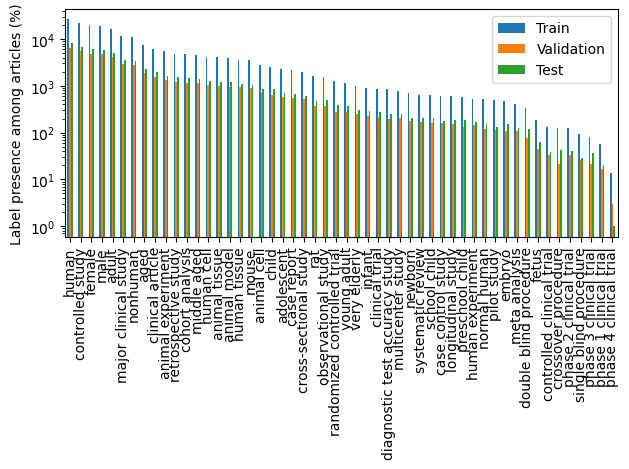

In [15]:
label_occurrences_train = label_columns.loc[label_columns.pui.isin(train_puis), label_columns.columns.difference(['pui'])].astype(int).sum().sort_values(ascending=False)
label_occurrences_val = label_columns.loc[label_columns.pui.isin(val_puis), label_columns.columns.difference(['pui'])].astype(int).sum().sort_values(ascending=False)
label_occurrences_test = label_columns.loc[label_columns.pui.isin(test_puis), label_columns.columns.difference(['pui'])].astype(int).sum().sort_values(ascending=False)
label_occurrences = pd.concat([label_occurrences_train,label_occurrences_val,label_occurrences_test], axis=1)
label_occurrences.rename({0: 'Train', 1: 'Validation', 2: 'Test'}, inplace=True, axis=1)
plt.figure(figsize = (30,5))
label_occurrences.plot(kind='bar')
plt.ylabel(f'Label presence among articles (%)')
plt.yscale('log')
plt.tight_layout()
plt.savefig(cc_path(f'reports/figures/data_split_label_occurrences/label_distribution.png'), dpi=300)

In [67]:
"""This file contains all the data processing that needs to be done to get to trainable data."""

import os
import sys
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")
from src.general.utils import cc_path

import pandas as pd
import numpy as np
import networkx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, add_remaining_self_loops
def convert_networkx_to_torch(sampled_graph: networkx.classes.graph.Graph, embedding_df: pd.DataFrame,
                       label_columns: pd.DataFrame, train_mask: torch.Tensor, val_mask: torch.Tensor, test_mask: torch.Tensor,
                       node_label_mapping: dict, embedding_type: str) -> Data:
    """
    Parse the networkx networks to a torch geometric format with node attributes

    Args:
        sampled_graph (networkx.classes.graph.Graph): A subsampled networkx graph
        embedding_df (pd.DataFrame): dataframe of standardised abstract embeddings
        label_columns (pd.DataFrame): dataframe with the labels
        train_mask (torch.Tensor): indices of train set
        test_mask (torch.Tensor): indices of test set
        node_label_mapping (dict): mapping between pui's and incremental reindexing
        embedding_type (str): the type of embedding that is used
    Returns:
        graph dataset in torch geometric format
    """
    
    if embedding_type == 'general' or embedding_type == 'scibert':
        node_features = embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                                               embedding_df.columns.difference(['pui'])].astype(
                                                  np.float32).to_numpy()
    elif embedding_type == 'label_specific':
        node_features = embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                         embedding_df.columns.difference(['pui'])].to_numpy()
    
        reshaped_node_features = np.zeros((len(node_features), len(node_features[0])*len(node_features[0][0])), dtype=np.double)
        for idx, embedding in enumerate(node_features):
            reshaped_node_features[idx, :]  = np.vstack(embedding).flatten()
            
        node_features = (reshaped_node_features - reshaped_node_features.mean())/(reshaped_node_features.std())
        node_features = node_features.astype(np.double)

        # node_features = reshaped_node_features_std.tolist()
            
    # set the node attributes (abstracts and labels) in the networkx graph for consistent processing later on
    networkx.set_node_attributes(sampled_graph,
                                 dict(zip(embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                                           'pui'].astype(str).to_list(),
                                          node_features)), 'x')
    networkx.set_node_attributes(sampled_graph,
                                 dict(zip(label_columns.loc[label_columns['pui'].isin(sampled_graph.nodes),
                                                           'pui'].astype(str).to_list(),
                                          label_columns.loc[label_columns['pui'].isin(sampled_graph.nodes),
                                                            label_columns.columns.difference(['pui'])].astype(
                                              np.float32).to_numpy())), 'y')

    # set the ids at incremental integers.
    sampled_graph = networkx.relabel_nodes(sampled_graph, node_label_mapping)

    # get the x and the y from the networkx graph
    # TODO: enforce order of list for piece of mind
    x = np.array([emb['x'] for (u, emb) in sampled_graph.nodes(data=True)])
    y = np.array([emb['y'] for (u, emb) in sampled_graph.nodes(data=True)])
    edge_weights = np.array([attrs['weight'] for a, b, attrs in sampled_graph.edges(data=True)])

    # create the torch data object for further training
    data = Data(x=torch.from_numpy(x),
                edge_index=torch.from_numpy(np.array(sampled_graph.edges(data=False), dtype=np.int32).T),
                y=torch.from_numpy(y),
                train_mask=train_mask,
                val_mask=val_mask,
                test_mask=test_mask,
                edge_weight=edge_weights, batch_size=64)

    data.edge_index = to_undirected(data.edge_index)
    data.edge_index, _ = add_remaining_self_loops(data.edge_index)

    return data

In [18]:
# create train and test split
print('Creating torch datasets...')

train_mask = get_mask(train_indices, len(sampled_author))
val_mask = get_mask(val_indices, len(sampled_author))
test_mask = get_mask(test_indices, len(sampled_author))
author_data = convert_networkx_to_torch(sampled_author, embedding_df, label_columns, train_mask, val_mask, test_mask,
                                 node_label_mapping, embedding_type)
keyword_data = convert_networkx_to_torch(sampled_keyword, embedding_df, label_columns, train_mask, val_mask, test_mask,
                                  node_label_mapping, embedding_type)

Creating torch datasets...


In [19]:
author_data.edge_index

tensor([[   3,    6,    8,  ..., 4997, 4998, 4999],
        [1879, 2933, 4584,  ..., 4997, 4998, 4999]])

In [20]:
from torch_geometric.utils import contains_self_loops,is_undirected
is_undirected(author_data.edge_index)

True

## Easy testing of model classes

In [53]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class ResidualConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(ResidualConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[-2]

class InitialConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(InitialConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[0]
    
class DenseConnection(torch.nn.Module):
    def __init__(self, in_dim, out_dim, aggregation='concat'):
        super(DenseConnection, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.aggregation = aggregation
        if aggregation == 'concat':
            self.layer_transform = torch.nn.Linear(in_dim, out_dim, bias=True)
        elif aggregation == 'attention':
            self.layer_att = torch.nn.Linear(512, 1, bias=True)

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        if self.aggregation == 'concat':
            X = torch.cat(Xs, dim=-1)
            X = self.layer_transform(X)
            return X
        elif self.aggregation == 'maxpool':
            X = torch.stack(Xs, dim=-1)
            X, _ = torch.max(X, dim=-1, keepdim=False)
            return X
        # implement with the code from https://github.com/mengliu1998/DeeperGNN/blob/master/DeeperGNN/dagnn.py
        elif self.aggregation == 'attention':
            # pps n x k+1 x c
            pps = torch.stack(Xs, dim=1)
            retain_score = self.layer_att(pps).squeeze()
            retain_score = torch.sigmoid(retain_score).unsqueeze(1)
            X = torch.matmul(retain_score, pps).squeeze()
            return X
        else:
            raise Exception("Unknown aggregation")

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, num_heads):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=num_heads))
        for i in range(2, num_layers):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))
        self.conv_last = GATv2Conv(hidden_channels*num_heads, out_channels, heads=num_heads)
        
        self.lin1 = torch.nn.Linear(hidden_channels*num_heads, out_channels)
        self.lin2 = torch.nn.Linear(out_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        # self.skip_layers = DenseConnection(hidden_channels * num_heads * (num_layers-1), out_channels, aggregation='attention')
        self.skip_layers = InitialConnection(alpha=0.5)

        
    def forward(self, x, edge_index):
        xs = []
        x1 = F.dropout(torch.relu(self.convs[0](x, edge_index)), p=0.6, training=self.training)
        xs.append(x1)
        x_new = x1

        for i in range(self.num_layers - 2):
            x_new = F.dropout(torch.relu(self.convs[i+1](x_new, edge_index)), p=0.1, training=self.training)
            xs.append(x_new)
        x_last = self.skip_layers(xs)
        
        x = F.relu(self.lin1(x_last))
        x = self.lin2(x)
        x = self.sigmoid(x)

        return x

    
model = GNN(author_data.x.shape[1], 64, 52, 4, 4)

In [27]:
"""This file defines the GCN single stream model."""

from torch_geometric.nn import GATConv
import torch
import torch.nn.functional as F


class dualGAT(torch.nn.Module):
    def __init__(self, hidden_channels, embedding_size, num_features, num_labels, num_conv_layers, heads, dropout):
        super().__init__()
        torch.manual_seed(1234567)
        
        # set parameters for forward function
        self.dropout = dropout
        self.num_layers = num_conv_layers
        
        # stream numero uno
        self.convs_1 = torch.nn.ModuleList()
        
        if self.num_layers > 1:
            self.convs.append(GATv2Conv(num_features, hidden_channels, heads))
            for i in range(2, self.num_layers):
                self.convs.append(GATv2Conv(heads * hidden_channels, hidden_channels, heads))
            self.convs.append(GATv2Conv(hidden_channels*heads, embedding_size, heads=heads))
        else:
            self.convs.append(GATv2Conv(num_features, embedding_size, heads))

        # stream numero dos
        self.convs_2 = torch.nn.ModuleList()
        
        if self.num_layers > 1:
            self.convs.append(GATv2Conv(num_features, hidden_channels, heads))
            for i in range(2, self.num_layers):
                self.convs.append(GATv2Conv(heads * hidden_channels, hidden_channels, heads))
            self.convs.append(GATv2Conv(hidden_channels*heads, embedding_size, heads=heads))
        else:
            self.convs.append(GATv2Conv(num_features, embedding_size, heads))

    def forward(self, x_1, edge_index_1, x_2, edge_index_2):
        
        # Process uno
        for i in range(self.num_layers):
            x_1 = F.dropout(F.elu(self.convs_1[i](x_1, edge_index_1)), p=self.dropout, training=self.training)

        # Process uno
        for i in range(self.num_layers):
            x_2 = F.dropout(F.elu(self.convs_2[i](x_2, edge_index_2)), p=self.dropout, training=self.training)

        out = (torch.sigmoid(x_1) + torch.sigmoid(x_2)) / 2

        return out

# Modelling

## Initiate Model

In [26]:
# initiate the model
model = initiate_model(
    gnn_type,
    all_model_parameters[gnn_type],
    num_features=author_data.x.shape[1],
    num_labels=len(label_columns.columns) - 1
)

AttributeError: 'dualGAT' object has no attribute 'num_layers'

In [23]:
print(model)

GAT(
  (convs): ModuleList(
    (0): GATv2Conv(768, 64, heads=4)
    (1): GATv2Conv(256, 64, heads=4)
    (2): GATv2Conv(256, 128, heads=4)
  )
  (linear_final_end): Linear(in_features=512, out_features=52, bias=True)
)


## pretrain Model

In [24]:
from src.models.pretraining import NegativeEdge, BatchAE, train_pretrain, DataLoaderAE


transform =  NegativeEdge()
transformed_author_data = transform(author_data)
pretrain_lr = 0.001
pretrain_weight_decay = 0.00001
pretrain_optimizer = 'adam'
pretrain_loss = 'BCEWithLogits'

#set up optimizer and criterion
if pretrain_optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)

if pretrain_loss == 'BCEWithLogits':
    criterion_pretrain = torch.nn.BCEWithLogitsLoss()


In [25]:
author_data.edge_index

tensor([[38119, 38119, 38119,  ..., 56334, 56335, 56336],
        [ 1395,  7824, 25485,  ..., 56334, 56335, 56336]])

Train acc: 0.7611202597618103, Train loss: 1.1525566577911377: 100%|██████████| 49/49 [04:45<00:00,  5.83s/it]


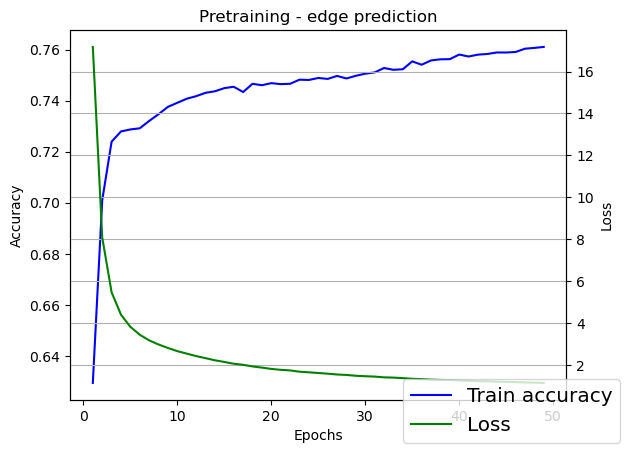

In [26]:

#optimizer = optim.Adam(model.graph_pred_linear.parameters(), lr=args.lr, weight_decay=args.decay)    


train_acc = 0
pretrain_epochs = 50
train_losses = []
train_accs = []
for epoch in (pbar := tqdm(range(1, pretrain_epochs))):
    model, train_acc, train_loss = train_pretrain(model, device, None, optimizer, BatchAE([transformed_author_data]).batch[0], criterion_pretrain)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    pbar.set_description(f'Train acc: {train_acc}, Train loss: {train_loss}')

fig, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(train_losses) + 1),train_accs , label='Train accuracy', c='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(np.arange(1, len(train_accs) + 1), train_losses, label='Loss', c='green')

plt.title(f'Pretraining - edge prediction')
fig.legend(loc='lower right', fontsize='x-large')
plt.grid()
plt.show()

torch.save(model, cc_path(f'models/pretrained_graphs/{run_id}_pretained.pt'))

## Try FocalLoss function

In [100]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super().__init__()
        self._gamma = gamma
        self._alpha = alpha

    def forward(self, y_pred, y_true):
        bceloss = torch.nn.BCELoss(reduction='none')
        cross_entropy_loss = bceloss(y_pred, y_true)
        p_t = ((y_true * y_pred) +
               ((1 - y_true) * (1 - y_pred)))
        modulating_factor = 1.0
        if self._gamma:
            modulating_factor = torch.pow(1.0 - p_t, self._gamma)
        alpha_weight_factor = 1.0
        if self._alpha is not None:
            alpha_weight_factor = (y_true * self._alpha +
                                   (1 - y_true) * (1 - self._alpha))
        focal_cross_entropy_loss = (modulating_factor * alpha_weight_factor *
                                    cross_entropy_loss)
        return focal_cross_entropy_loss.mean()

## run test prediction

In [27]:
model.eval()

all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

# get the output of an untrained model
data = [all_torch_data[datatype] for datatype in data_type_to_use]
print('This is the data object: ', data)
data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

# model.set_label_embeddings(*data_inputs[3:])

out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())
# visualize(out, color=data.y.argmax(dim=1))

This is the data object:  [Data(x=[56337, 768], edge_index=[2, 119992], y=[56337, 52], train_mask=[56337], val_mask=[56337], test_mask=[56337], edge_weight=[31870], batch_size=64)]
The predictions of the test set before training:  [[0.46245143 0.50196487 0.5072953  ... 0.52114093 0.51121277 0.50623685]
 [0.474523   0.4882008  0.52194625 ... 0.46771455 0.49267855 0.49361774]
 [0.48943907 0.48219088 0.48998025 ... 0.5229049  0.5174183  0.49701545]
 ...
 [0.51970243 0.465065   0.45730084 ... 0.5037705  0.509034   0.49667487]
 [0.527428   0.47466487 0.50155497 ... 0.4859196  0.51077276 0.4803653 ]
 [0.50064987 0.47295928 0.50589514 ... 0.5033807  0.5022896  0.48866767]]


### Set model training parameters

In [28]:
# set training parameters
print('Start training procedure...')

graph_optimizer = 'adam'
graph_lr = 0.001
graph_weight_decay = 1e-4
graph_loss = 'BCELoss'
graph_fl_gamma = 2.8
graph_fl_alpha = 0.25

if graph_optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=graph_lr, weight_decay=graph_weight_decay)

# label_occs = label_columns[label_columns.columns.difference(['pui'])].sum().to_list()
# weight = torch.tensor(label_occs) / sum(label_occs)

if graph_loss == 'BCELoss':
    criterion = torch.nn.BCELoss()
elif graph_loss == 'FocalLoss':
    criterion = FocalLoss(gamma=graph_fl_gamma, alpha=graph_fl_alpha)

Start training procedure...


### Train model

In [37]:
# train model
all_metrics = evaluate_metrics(model, data, dataset='train').keys()
train_metrics_all = {key: [] for key in all_metrics}
val_metrics_all = {key: [] for key in all_metrics}
test_metrics_all = {key: [] for key in all_metrics}
loss_all = []

graph_num_epochs = 50
for epoch in (pbar := tqdm(range(1, graph_num_epochs))):
    loss = train(model, data, optimizer, criterion)

    train_metrics = evaluate_metrics(model, data, dataset='train', show=False)
    val_metrics = evaluate_metrics(model, data, dataset='val', show=False)
    test_metrics = evaluate_metrics(model, data, dataset='test', show=False)

    for metric in train_metrics.keys():
        train_metrics_all[metric].append(train_metrics[metric])
        val_metrics_all[metric].append(val_metrics[metric])
        test_metrics_all[metric].append(test_metrics[metric])

    loss_all.append(loss.item())
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train - F1 {train_metrics['Macro F1 score']}, Val - F1 {val_metrics['Macro F1 score']}")

torch.save(model, cc_path(f'models/supervised_graphs/{run_id}_supervised.pt'))
    
print(test_metrics)

Epoch: 049, Loss: 0.1038, Train - F1 0.5325248438009292, Val - F1 0.5255147259656497: 100%|██████████| 49/49 [06:05<00:00,  7.46s/it]

{'Precision': [0.6941176470588235, 0.8378224582701063, 0.7101736972704714, 0.7120786516853933, 0.8783399658897101, 0.8253477588871716, 0.740484429065744, 0.9108910891089109, 0.9477726574500768, 0.8338709677419355, 0.8776203966005666, 0.6865671641791045, 0.8760643330179754, 0.0, 0.769629437678155, 0.911062906724512, 0.6666666666666666, 0.696078431372549, 0.8309859154929577, 0.7619047619047619, 0.8989541160593792, 0.7142857142857143, 0.9688190522956052, 0.7829525483304042, 0.6567164179104478, 0.7635135135135135, 0.6632653061224489, 0.8536585365853658, 0.8772075055187638, 0.8803843074459567, 0.8, 0.7540983606557377, 0.9192118226600985, 0.7868852459016393, 0.625, 0.9249688667496887, 0.7142857142857143, 0.9377593360995851, 0.0, 0.6666666666666666, 0.0, 0.0, 0.8536585365853658, 0.5, 0.8738170347003155, 0.9298642533936652, 0.9077551020408163, 0.3333333333333333, 0.0, 0.8306878306878307, 0.5, 0.0], 'Recall': [0.33810888252148996, 0.8386178089994304, 0.6091954022988506, 0.5393617021276595, 0.87

### Model Evaluation

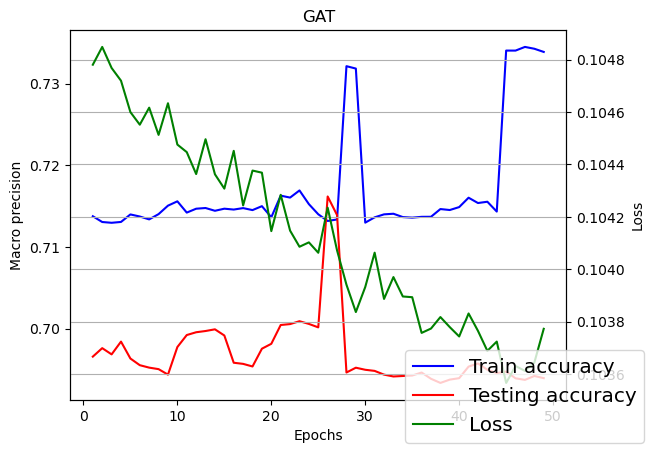

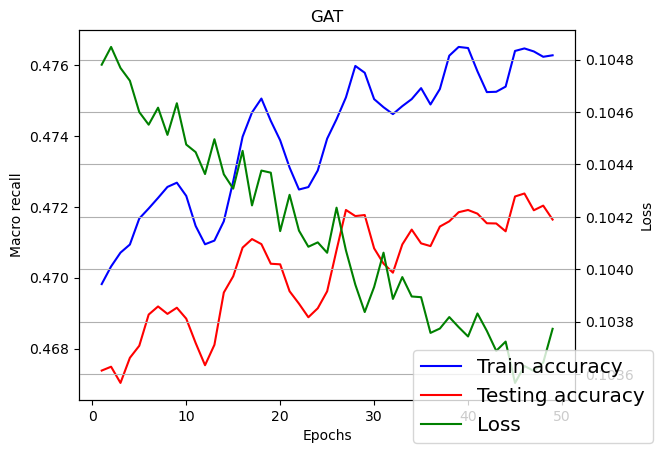

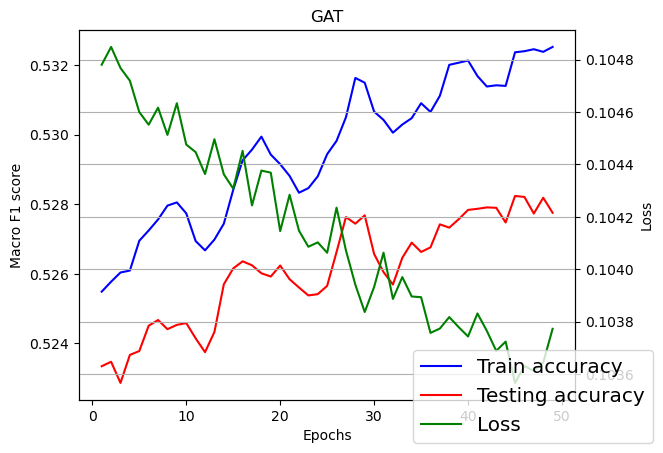

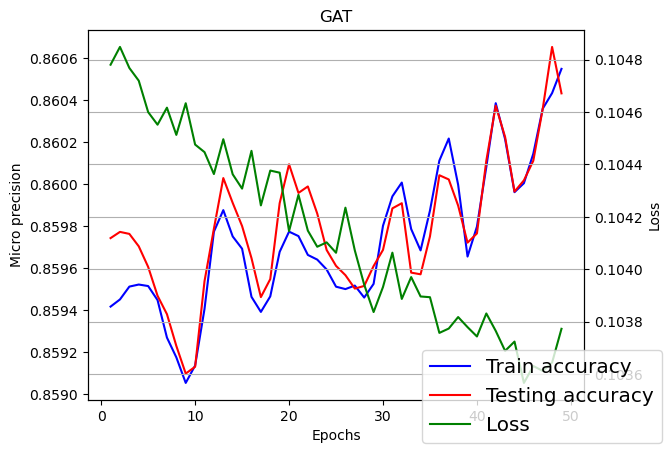

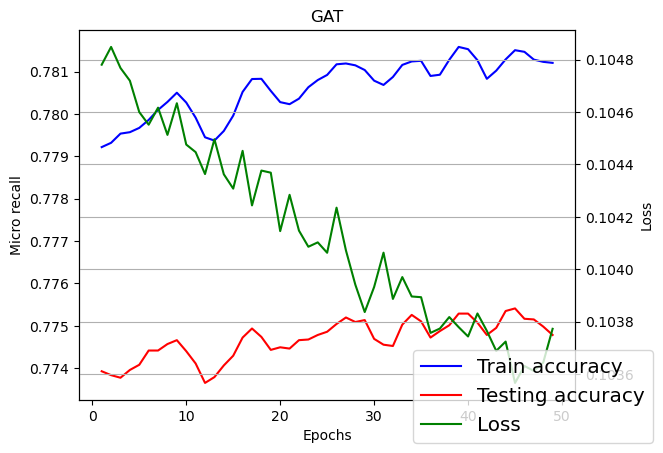

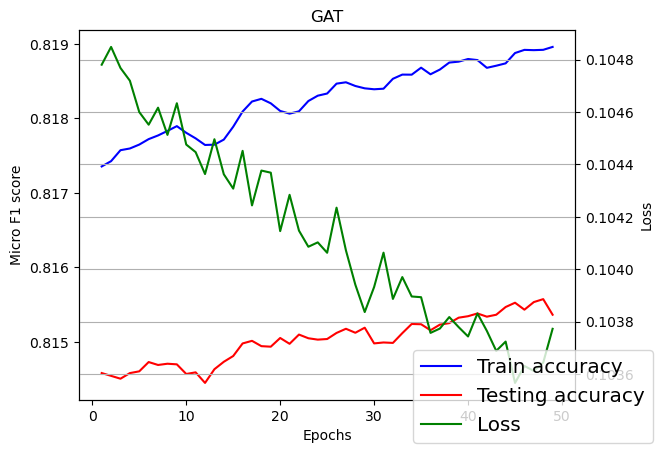

The predictions of the test set before training:  [[0.00086138 0.03466994 0.00354908 ... 0.00140326 0.00088077 0.00184206]
 [0.00290055 0.0201548  0.00160474 ... 0.00253883 0.00043485 0.00134834]
 [0.0012317  0.0071469  0.00086012 ... 0.00170639 0.00032386 0.0006187 ]
 ...
 [0.13637322 0.01976833 0.01112797 ... 0.00307802 0.00221791 0.02164032]
 [0.00281601 0.01351609 0.00201519 ... 0.00085761 0.00053291 0.00152462]
 [0.00085451 0.00869557 0.00070591 ... 0.00027142 0.00020866 0.00043777]]
Evaluating model performance...
The metrics:  {'Precision': [0.6989795918367347, 0.844529292447202, 0.7203047263681592, 0.7002700270027002, 0.8752064599008993, 0.8370277078085643, 0.7376721457130164, 0.945859872611465, 0.9461615154536391, 0.8124162572577043, 0.8784979238129627, 0.6784869976359338, 0.8726993865030674, 0.0, 0.7681621774421517, 0.9135021097046413, 0.8666666666666667, 0.6805555555555556, 0.8185840707964602, 0.7846153846153846, 0.8988952301167601, 0.7222222222222222, 0.9684665722704834, 0.

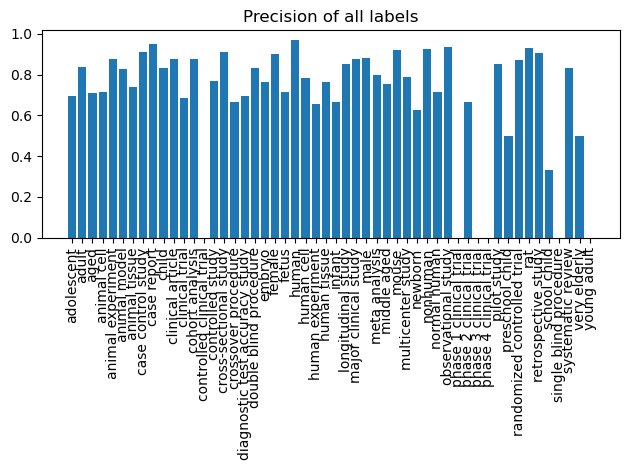

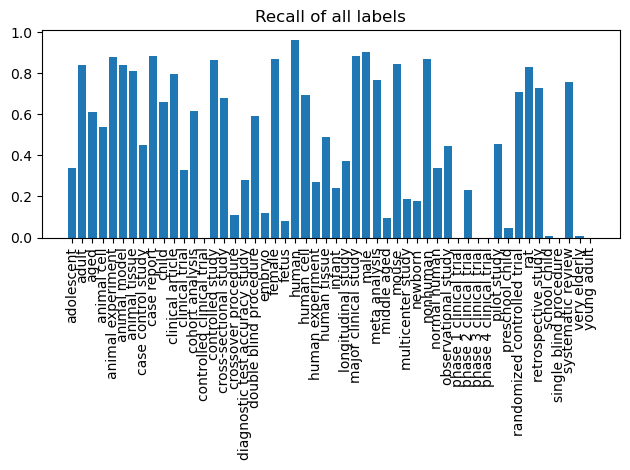

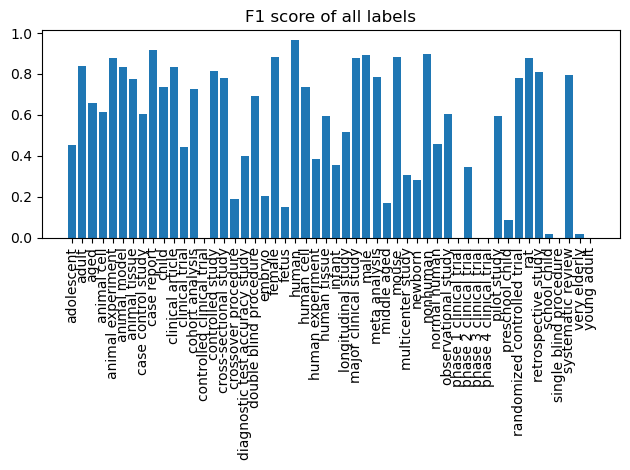

In [39]:
import matplotlib.pyplot as plt
today = datetime.date.today()
now = datetime.datetime.now()
time = now.strftime("%H-%M-%S")

image_path = cc_path(f'reports/figures/classification_results/{today}/')
if not os.path.exists(image_path):
    os.mkdir(image_path)
os.mkdir(image_path + f'{time}/')
for metric in all_metrics:
    if 'Micro' in metric or 'Macro' in metric:
        plot_metrics_during_training(train_metrics_all[metric], test_metrics_all[metric], loss_all, model_name=gnn_type, metric_name=metric, today=today, time=time)


# get output from trained model
model.eval()
out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())

# get the test accuracy
print('Evaluating model performance...')
train_end_metrics = evaluate_metrics(model, data, dataset='train', show=True)
val_end_metrics = evaluate_metrics(model, data, dataset='val', show=True)
test_end_metrics = evaluate_metrics(model, data, dataset='test', show=True)


for metric in all_metrics:
    if not 'Micro' in metric and not 'Macro' in metric:
        plt.figure()
        plt.title(f'{metric} of all labels')
        plt.bar(range(len(label_columns.columns.difference(['pui']))), test_end_metrics[metric], tick_label=label_columns.columns.difference(['pui']))
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{gnn_type}_{metric}_label.png'))
        plt.show()

# print(f'Test Accuracy: {test_acc:.4f}')

# visualize(out, color=data.y.argmax(dim=1))

### train classification head on graph node embeddings

In [40]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as gbm

In [ ]:
graph_created_embeddings = model.forward(data_inputs[0], data_inputs[1], return_embeddings=True)
X_train_graph_embeddings = graph_created_embeddings[data[0].train_mask].detach().numpy()
X_val_graph_embeddings = graph_created_embeddings[data[0].val_mask].detach().numpy()
X_test_graph_embeddings = graph_created_embeddings[data[0].test_mask].detach().numpy()

y_train_graph_embeddings = data[0].y[data[0].train_mask].detach().numpy()
y_val_graph_embeddings = data[0].y[data[0].val_mask].detach().numpy()
y_test_graph_embeddings = data[0].y[data[0].test_mask].detach().numpy()

In [42]:
# create a classifier for each class
lgbm_params = {
    'n_estimators': 500,
    'is_unbalance': True,
    'n_jobs': -1
}

num_labels = 52
clfs = []
for i in range(num_labels):
    clfs.append(gbm.LGBMClassifier(**lgbm_params))


In [43]:
for i in tqdm(range(num_labels)):
     clfs[i] = clfs[i].fit(X_train_graph_embeddings, y_train_graph_embeddings[:, i], callbacks=[gbm.log_evaluation(period=100), gbm.early_stopping(30)], eval_set=(X_val_graph_embeddings, y_val_graph_embeddings[:, i]))
    
# Save the list of trained models to a file
with open(cc_path(f'models/classification_heads/{run_id}_classification_head.pkl'), 'wb') as f:
    pickle.dump(clfs, f)


  0%|          | 0/52 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds


  2%|▏         | 1/52 [00:02<02:23,  2.82s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.254694
Training until validation scores don't improve for 30 rounds


  4%|▍         | 2/52 [00:05<02:14,  2.69s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.689814
Training until validation scores don't improve for 30 rounds


  6%|▌         | 3/52 [00:09<02:36,  3.20s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.519674
Training until validation scores don't improve for 30 rounds


  8%|▊         | 4/52 [00:12<02:31,  3.15s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.289096
Training until validation scores don't improve for 30 rounds


 10%|▉         | 5/52 [00:14<02:18,  2.95s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.426164
Training until validation scores don't improve for 30 rounds


 12%|█▏        | 6/52 [00:18<02:20,  3.04s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.349652
Training until validation scores don't improve for 30 rounds


 13%|█▎        | 7/52 [00:20<02:11,  2.93s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.354473
Training until validation scores don't improve for 30 rounds


 15%|█▌        | 8/52 [00:23<02:08,  2.91s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.323134
Training until validation scores don't improve for 30 rounds


 17%|█▋        | 9/52 [00:26<02:01,  2.82s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.248142
Training until validation scores don't improve for 30 rounds


 19%|█▉        | 10/52 [00:29<01:58,  2.82s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.274249
Training until validation scores don't improve for 30 rounds


 21%|██        | 11/52 [00:31<01:54,  2.78s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.461118
Training until validation scores don't improve for 30 rounds


 23%|██▎       | 12/52 [00:34<01:53,  2.85s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.215855
Training until validation scores don't improve for 30 rounds


 25%|██▌       | 13/52 [00:37<01:47,  2.75s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.389473
Training until validation scores don't improve for 30 rounds


 27%|██▋       | 14/52 [00:40<01:47,  2.82s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 1.24866
Training until validation scores don't improve for 30 rounds


 29%|██▉       | 15/52 [00:42<01:41,  2.76s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.671074
Training until validation scores don't improve for 30 rounds


 31%|███       | 16/52 [00:46<01:48,  3.01s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.246489
Training until validation scores don't improve for 30 rounds


 33%|███▎      | 17/52 [00:49<01:49,  3.12s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 1.50273
Training until validation scores don't improve for 30 rounds


 35%|███▍      | 18/52 [00:52<01:43,  3.05s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.223743
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.0976494


 35%|███▍      | 18/52 [01:00<01:54,  3.38s/it]


KeyboardInterrupt: 

In [125]:
# Load the list of models from the file
with open(cc_path(f'models/classification_heads/{run_id}_classification_head.pkl'), 'rb') as f:
    clfs = pickle.load(f)

y_test_pred = np.zeros((X_test_graph_embeddings.shape[0], num_labels))
y_val_pred = np.zeros((X_val_graph_embeddings.shape[0], num_labels))
y_train_pred = np.zeros((X_train_graph_embeddings.shape[0], num_labels))

for i in tqdm(range(num_labels)):
    y_test_pred[:, i] = clfs[i].predict(X_test_graph_embeddings)
    y_val_pred[:, i] = clfs[i].predict(X_val_graph_embeddings)
    y_train_pred[:, i] = clfs[i].predict(X_train_graph_embeddings)


100%|██████████| 52/52 [00:00<00:00, 107.68it/s]


In [126]:
from sklearn.metrics import f1_score, recall_score, precision_score
final_clf_head_metrics = {}
for dataset_name, (dataset_pred, dataset_real) in {'train': (y_train_pred, y_train_graph_embeddings), 'val': (y_val_pred, y_val_graph_embeddings), 'test': (y_test_pred, y_test_graph_embeddings)}.items():
    for metric_name, metric in {'f1_score': f1_score, 'recall': recall_score, 'precision': precision_score}.items():
        for averaging_type in ['macro', 'micro']:
            score = metric(dataset_real, dataset_pred, average=averaging_type, zero_division=1)
            print(f'{dataset_name}: {averaging_type} - {metric_name}: {score}')
            final_clf_head_metrics[f'lgbm_{dataset_name}_{metric_name}_{averaging_type}'] = score

train: macro - f1_score: 0.8484025075663784
train: micro - f1_score: 0.9303405990870539
train: macro - recall: 0.8852459642136872
train: micro - recall: 0.939193979385941
train: macro - precision: 0.8588134717652196
train: micro - precision: 0.9216525741196617
val: macro - f1_score: 0.498235305754541
val: micro - f1_score: 0.7457777777777779
val: macro - recall: 0.5099214164518459
val: micro - recall: 0.7343544857768053
val: macro - precision: 0.5262728767954126
val: micro - precision: 0.7575620767494357
test: macro - f1_score: 0.4787114010562694
test: micro - f1_score: 0.7206545333110703
test: macro - recall: 0.49789822004516204
test: micro - recall: 0.7097516855780299
test: macro - precision: 0.49924777385534286
test: micro - precision: 0.731897575038155


## Save all results

In [127]:
results_df = pd.read_csv(cc_path(f'reports/model_results/model_log.csv'))



In [129]:
results = {
    'date': now, 
    'id': run_id, 
    'gnn_type': gnn_type,
    'graph_train_f1_score_macro': train_end_metrics['Macro F1 score'],
    'graph_train_precision_macro': train_end_metrics['Macro precision'], 
    'graph_train_recall_macro': train_end_metrics['Macro recall'], 
    'graph_train_f1_score_micro': train_end_metrics['Micro F1 score'],
    'graph_train_precision_micro': train_end_metrics['Micro precision'], 
    'graph_train_recall_micro': train_end_metrics['Micro recall'], 
    'graph_val_f1_score_macro': val_end_metrics['Macro F1 score'],
    'graph_val_precision_macro': val_end_metrics['Macro precision'], 
    'graph_val_recall_macro': val_end_metrics['Macro recall'], 
    'graph_val_f1_score_micro': val_end_metrics['Micro F1 score'],
    'graph_val_precision_micro': val_end_metrics['Micro precision'], 
    'graph_val_recall_micro': val_end_metrics['Micro recall'], 
    'graph_test_f1_score_macro': test_end_metrics['Macro F1 score'],
    'graph_test_precision_macro': test_end_metrics['Macro precision'], 
    'graph_test_recall_macro': test_end_metrics['Macro recall'], 
    'graph_test_f1_score_micro': test_end_metrics['Micro F1 score'],
    'graph_test_precision_micro': test_end_metrics['Micro precision'], 
    'graph_test_recall_micro': test_end_metrics['Micro recall'], 
    'lgbm_train_f1_score_macro': final_clf_head_metrics['lgbm_train_f1_score_macro'],
    'lgbm_train_precision_macro': final_clf_head_metrics['lgbm_train_precision_macro'], 
    'lgbm_train_recall_macro': final_clf_head_metrics['lgbm_train_recall_macro'], 
    'lgbm_train_f1_score_micro': final_clf_head_metrics['lgbm_train_f1_score_micro'],
    'lgbm_train_precision_micro': final_clf_head_metrics['lgbm_train_precision_micro'], 
    'lgbm_train_recall_micro': final_clf_head_metrics['lgbm_train_recall_micro'], 
    'lgbm_val_f1_score_macro': final_clf_head_metrics['lgbm_val_f1_score_macro'],
    'lgbm_val_precision_macro': final_clf_head_metrics['lgbm_val_precision_macro'], 
    'lgbm_val_recall_macro': final_clf_head_metrics['lgbm_val_recall_macro'], 
    'lgbm_val_f1_score_micro': final_clf_head_metrics['lgbm_val_f1_score_micro'],
    'lgbm_val_precision_micro': final_clf_head_metrics['lgbm_val_precision_micro'], 
    'lgbm_val_recall_micro': final_clf_head_metrics['lgbm_val_recall_micro'],
    'lgbm_test_f1_score_macro': final_clf_head_metrics['lgbm_test_f1_score_macro'],
    'lgbm_test_precision_macro': final_clf_head_metrics['lgbm_test_precision_macro'], 
    'lgbm_test_recall_macro': final_clf_head_metrics['lgbm_test_recall_macro'], 
    'lgbm_test_f1_score_micro': final_clf_head_metrics['lgbm_test_f1_score_micro'],
    'lgbm_test_precision_micro': final_clf_head_metrics['lgbm_test_precision_micro'], 
    'lgbm_test_recall_micro': final_clf_head_metrics['lgbm_test_recall_micro'], 
    'num_samples': subsample_size,
    'embedding_type': embedding_type, 
    'edge_weight_threshold': edge_weight_threshold,
    'pretrain_epochs': pretrain_epochs, 
    'pretrain_lr': pretrain_lr,
    'pretrain_weight_decay': pretrain_weight_decay,
    'pretrain_optimizer': pretrain_optimizer,
    'pretrain_loss': pretrain_loss,
    'graph_num_epochs': graph_num_epochs, 
    'graph_optimizer': graph_optimizer,
    'graph_lr':graph_lr,
    'graph_weight_decay': graph_weight_decay,
    'graph_loss': graph_loss,
    'graph_fl_gamma': graph_fl_gamma,
    'graph_fl_alpha': graph_fl_alpha,
    'layers': all_model_parameters[gnn_type].get('num_conv_layers'),
    'heads': all_model_parameters[gnn_type].get('heads'), 
    'emb_size': all_model_parameters[gnn_type].get('embedding_size'), 
    'hidden_channels': all_model_parameters[gnn_type].get('hidden_channels'), 
    'dropout': all_model_parameters[gnn_type].get('dropout'), 
    'lgbm_params': str(lgbm_params)
}

In [130]:
results_df = pd.concat([results_df, pd.Series(results).to_frame().T], ignore_index=True)

In [131]:
results_df.to_csv(cc_path(f'reports/model_results/model_log.csv'), index=False)